In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from utils2 import *

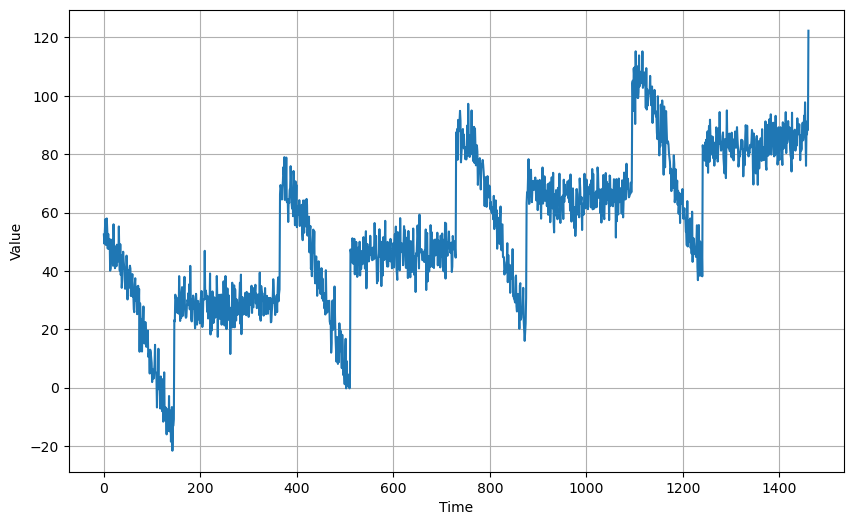

In [2]:
# Parameters
time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

# Update with noise
series += noise(time, noise_level, seed=42)

# Plot the results
plot_series(time, series)

## Split the Dataset

In [3]:
# Define the split time
split_time = 1000

# Get the train set 
time_train = time[:split_time]
x_train = series[:split_time]

# Get the validation set
time_valid = time[split_time:]
x_valid = series[split_time:]

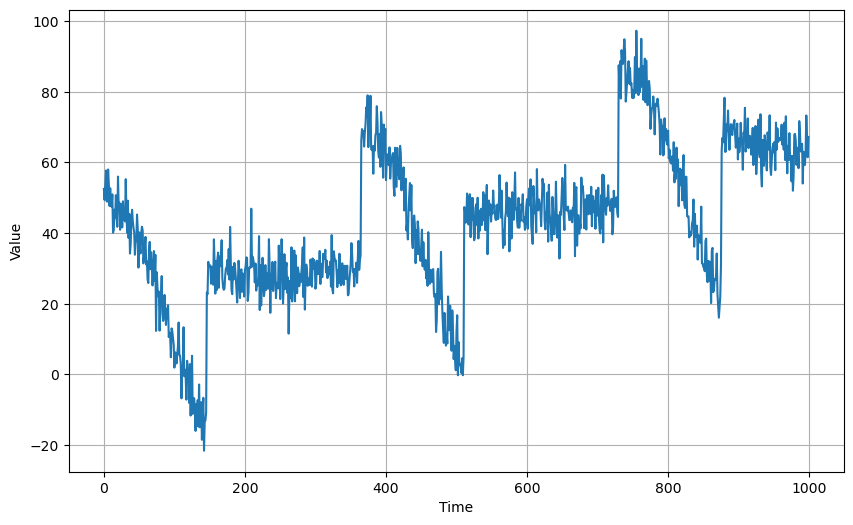

In [4]:
# Plot the train set
plot_series(time_train, x_train)

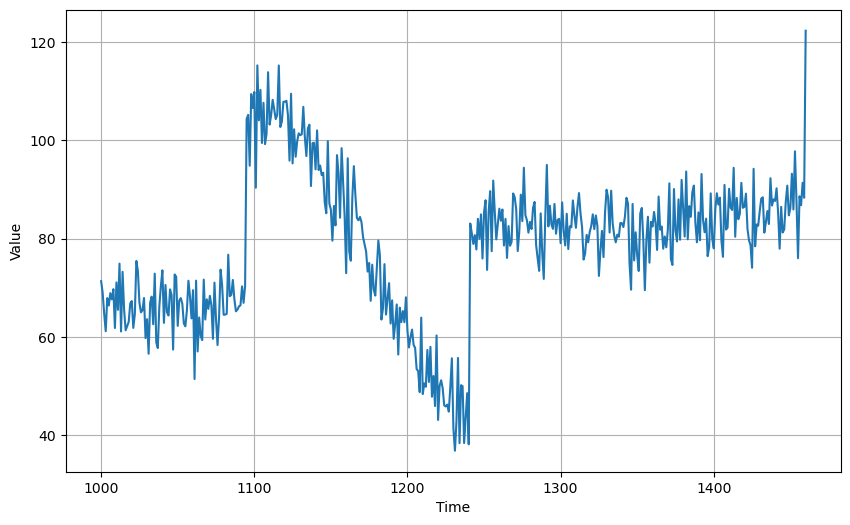

In [5]:
# Plot the validation set
plot_series(time_valid, x_valid)

## Prepare features and labels

One thing to note here is the window_size + 1 when you call dataset.window(). There is a + 1 to indicate that you're taking the next point as the label. For example, the first 20 points will be the feature so the 21st point will be the label.

In [6]:
# Parameters
window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    """Generates dataset windows

    Args:
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the feature
      batch_size (int) - the batch size
      shuffle_buffer(int) - buffer size to use for the shuffle method

    Returns:
      dataset (TF Dataset) - TF Dataset containing time windows
    """
  
    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)
    
    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    
    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Create tuples with features and labels 
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Shuffle the windows
    dataset = dataset.shuffle(shuffle_buffer)
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    return dataset

In [7]:
# Generate the dataset windows
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

# Print properties of a single batch
for windows in dataset.take(1):
    print(f'data type: {type(windows)}')
    print(f'number of elements in the tuple: {len(windows)}')
    print(f'shape of first element: {windows[0].shape}')
    print(f'shape of second element: {windows[1].shape}')

data type: <class 'tuple'>
number of elements in the tuple: 2
shape of first element: (32, 20)
shape of second element: (32,)


## Build and compile the model

In [10]:
# Build the single layer neural network
l0 = tf.keras.layers.Dense(1, input_shape=[window_size])
model = tf.keras.models.Sequential([l0])

# Print the initial layer weights
print("Layer weights: \n {} \n".format(l0.get_weights()))

# Print the model summary
model.summary()

Layer weights: 
 [array([[-0.19312972],
       [ 0.5112044 ],
       [ 0.22526783],
       [-0.12419903],
       [ 0.36745602],
       [-0.31932715],
       [ 0.14984608],
       [ 0.14874524],
       [ 0.17335278],
       [ 0.29700756],
       [ 0.47796875],
       [-0.4886419 ],
       [-0.40850717],
       [-0.05317998],
       [ 0.26635832],
       [-0.14703768],
       [-0.29418206],
       [-0.08012593],
       [ 0.4653569 ],
       [ 0.31476045]], dtype=float32), array([0.], dtype=float32)] 

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 1)                 21        
                                                                 
Total params: 21
Trainable params: 21
Non-trainable params: 0
_________________________________________________________________


In [11]:
# Set the training parameters
model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9))

## Train the Model

In [12]:
# Train the model
model.fit(dataset,epochs=100)

Epoch 1/100
31/31 [==============================] - 2s 42ms/step - loss: 177.7692
Epoch 2/100
31/31 [==============================] - 0s 700us/step - loss: 127.3898
Epoch 3/100
31/31 [==============================] - 0s 633us/step - loss: 107.4310
Epoch 4/100
31/31 [==============================] - 0s 633us/step - loss: 93.9369
Epoch 5/100
31/31 [==============================] - 0s 633us/step - loss: 86.9589
Epoch 6/100
31/31 [==============================] - 0s 667us/step - loss: 83.0782
Epoch 7/100
31/31 [==============================] - 0s 667us/step - loss: 78.4897
Epoch 8/100
31/31 [==============================] - 0s 667us/step - loss: 76.7060
Epoch 9/100
31/31 [==============================] - 0s 633us/step - loss: 74.9427
Epoch 10/100
31/31 [==============================] - 0s 633us/step - loss: 72.4160
Epoch 11/100
31/31 [==============================] - 0s 667us/step - loss: 71.5437
Epoch 12/100
31/31 [==============================] - 0s 667us/step - loss: 71.3871

31/31 [==============================] - 0s 600us/step - loss: 44.2430
Epoch 99/100
31/31 [==============================] - 0s 700us/step - loss: 44.2149
Epoch 100/100
31/31 [==============================] - 0s 667us/step - loss: 44.3049


In [13]:
# Print the layer weights
print("Layer weights {}".format(l0.get_weights()))

Layer weights [array([[-0.08309942],
       [ 0.06172164],
       [ 0.05092249],
       [-0.06686673],
       [ 0.08138372],
       [-0.05616577],
       [ 0.01228771],
       [-0.00985944],
       [-0.01500944],
       [ 0.04539364],
       [ 0.0902336 ],
       [-0.09399792],
       [-0.08801112],
       [ 0.04984229],
       [ 0.1067696 ],
       [ 0.03095149],
       [-0.01443746],
       [ 0.12606442],
       [ 0.34474525],
       [ 0.4348117 ]], dtype=float32), array([0.01263695], dtype=float32)]


## Model Prediction

In [14]:
# Shape of the first 20 data points slice
print(f'shape of series[0:20]: {series[0:20].shape}')

# Shape after adding a batch dimension
print(f'shape of series[0:20][np.newaxis]: {series[0:20][np.newaxis].shape}')

# Shape after adding a batch dimension (alternate way)
print(f'shape of series[0:20][np.newaxis]: {np.expand_dims(series[0:20], axis=0).shape}')

# Sample model prediction
print(f'model prediction: {model.predict(series[0:20][np.newaxis])}')

shape of series[0:20]: (20,)
shape of series[0:20][np.newaxis]: (1, 20)
shape of series[0:20][np.newaxis]: (1, 20)
1/1 [==============================] - 0s 54ms/step
model prediction: [[43.040485]]


In [15]:
# Initialize a list
forecast = []

# Use the model to predict data points per window size
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

# Slice the points that are aligned with the validation set
forecast = forecast[split_time - window_size:]

# Compare number of elements in the predictions and the validation set
print(f'length of the forecast list: {len(forecast)}')
print(f'shape of the validation set: {x_valid.shape}')

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step
length of the forecast list: 461
shape of the validation set: (461,)


shape after converting to numpy array: (461, 1, 1)
shape after squeezing: (461,)


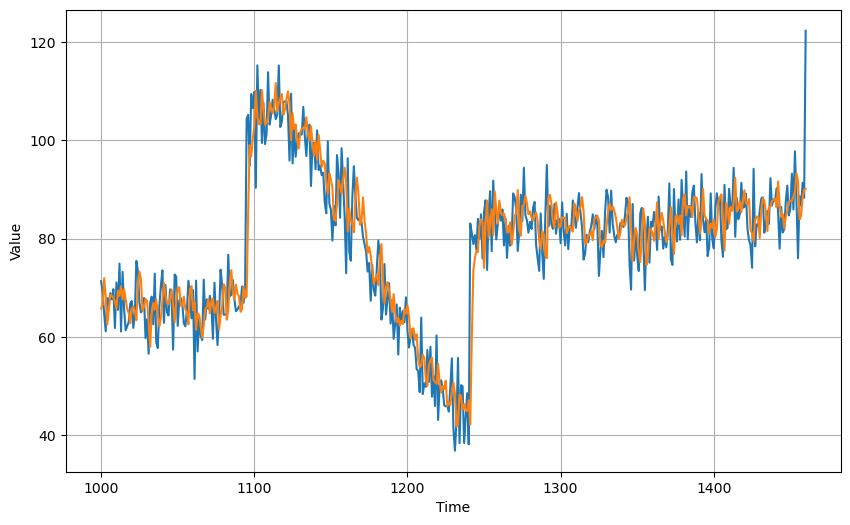

In [16]:
# Preview shapes after using the conversion and squeeze methods
print(f'shape after converting to numpy array: {np.array(forecast).shape}')
print(f'shape after squeezing: {np.array(forecast).squeeze().shape}')

# Convert to a numpy array and drop single dimensional axes
results = np.array(forecast).squeeze()

# Overlay the results with the validation set
plot_series(time_valid, (x_valid, results))

In [17]:
# Compute the metrics
print(tf.keras.metrics.mean_squared_error(x_valid, results).numpy())
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

46.66613
5.0991654
